In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import h5py
import pandas as pd

from importlib import reload
from matplotlib import pyplot as plt

from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin

from labtools.mplplots import init_nb_plotting
reload(init_nb_plotting)
from labtools.mplplots.init_nb_plotting import *

from labtools.mplplots import plots as mplplots
from labtools.mplplots import tools as mpltools

In [3]:
def get_data(fp):
    with h5py.File(fp, 'r') as f:
        g = f['raw']
        bias = g['Current']['Bias [V]'][:].reshape(-1)
        current = g['Current']['Current [A]'][:].reshape(-1)
        voltage = g['Voltage']['Voltage [V]'][:].reshape(-1)
    return bias, current, voltage


# def get_100mK_example_data():
#     fp = 


def smooth(x, window_len=10):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = np.ones(window_len,'d')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[int(window_len/2-1):int(-window_len/2)]


def find_offset(i, v, i_th=0.05, delta=1e-9, max_it=100, smooth_win=50):
    ifunc = interp1d(v, smooth(i, smooth_win), fill_value='extrapolate')
    v_guess = v[np.argmin(abs(i-i_th))] 
#     print(v_guess)
    v_pos = v_guess
    v_neg = -v_guess
    v_of = 0
    i_of = 0
    
    for k in range(max_it):
#         print(k, v_of, i_of)        
        # for each iteration:
        # 1) using current i/v offsets, find v where i exceeds the threshold (both pos and neg side)
        # 2) update the v-offset by adding the mean of the new found values to the current one
        # 3) update i-offset (just the function value of i at the new 'zero' v value)
        v_pos = fmin(lambda v: abs(ifunc(v+v_of)-i_th-i_of), v_pos, disp=0, xtol=1e-8, ftol=1e-8)
        v_neg = fmin(lambda v: abs(ifunc(v+v_of)+i_th-i_of), v_neg, disp=0, xtol=1e-8, ftol=1e-8)
        v_of_new = v_of + (v_pos+v_neg)/2.
        
        if abs(v_of - v_of_new) < delta:
            v_of = v_of_new
            i_of = ifunc(v_of)
            break

        v_of = v_of_new
        i_of = ifunc(v_of)
        
        return i_of, v_of
    
    
def process_data(bias, current, voltage, R):    
    bias *= 1e6
    voltage *= -1e6
    current *= 1e9
    
    voltage -= voltage.mean()
    
    
    current -= current[current.size//2]

    iof, bof = find_offset(current, bias)
    bias -= bof
    current -= iof
    
    bias -= current * R * 1e-3

    _, vof = find_offset(current, voltage)
    voltage -= vof
    
    return bias, current, voltage


def get_fit_lims(current, smoothwin=25):
    di = np.diff(smooth(current, smoothwin))[smoothwin//2:-smoothwin//2]
    base = di[di.size//4:-di.size//4]
    std = np.std(base)
    th = base.mean() + noise_sigmas * std
    idx0 = np.argmin(abs(di[:di.size//2]-th)) + smoothwin//2
    idx1 = np.argmin(abs(di[di.size//2:]-th)) + di.size//2 + smoothwin//2
    return idx0, idx1


def fit_linslope(i, v, ilim=None, vlim=None):
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        fltr = slice(None, None, None)
        
    i2 = i[fltr]
    v2 = v[fltr]
    p = np.polyfit(np.log(i2[i2>0]), v2[i2>0], 1)
    i_linfit = np.exp((v2-p[1])/p[0])
    T_slope = constants.e * p[0] * 1e-6 / constants.k
    
    return v2, i_linfit, T_slope


def fit_temperature(fp, plot=True, save_plot=True):
    bias, current, voltage = process_data(*get_data(fp), R=R)
    idx0, idx1 = get_fit_lims(current)

    bias_vfit1, bias_ifit1, bias_T1 = fit_linslope(current[idx1:], bias[idx1:], ilim=(0, ilim))
    bias_vfit0, bias_ifit0, bias_T0 = fit_linslope(-current[:idx0], -bias[:idx0], ilim=(0, ilim))
    bias_T0 *= 1e3
    bias_T1 *= 1e3

    v_vfit1, v_ifit1, v_T1 = fit_linslope(current[idx1:], voltage[idx1:], ilim=(0, ilim))
    v_vfit0, v_ifit0, v_T0 = fit_linslope(-current[:idx0], -voltage[:idx0], ilim=(0, ilim))
    v_T0 *= 1e3
    v_T1 *= 1e3

    
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(4,3))
        ax.plot(bias, current, 'ro', ms=1, alpha=0.5, label=f'T = {bias_T0:.0f}, {bias_T1:.0f} mK')
        ax.plot(voltage + v_ofs[0], current + v_ofs[1], 'bo', ms=1, alpha=0.5, label=f'T = {v_T0:.0f}, {v_T1:.0f} mK')

        # ax.axvline(bias[idx0], color='r', lw=1, dashes=[3,3])
        # ax.axvline(bias[idx1], color='r', lw=1, dashes=[3,3])
        # ax.axvline(voltage[idx0] + v_ofs[0], color='b', lw=1, dashes=[3,3])
        # ax.axvline(voltage[idx1] + v_ofs[0], color='b', lw=1, dashes=[3,3])

        ax.plot(bias_vfit1, bias_ifit1, 'k-')
        ax.plot(-bias_vfit0, -bias_ifit0, 'k-')

        ax.plot(v_vfit1 + v_ofs[0], v_ifit1 + v_ofs[1], 'k-')
        ax.plot(-v_vfit0 + v_ofs[0], -v_ifit0 + v_ofs[1], 'k-')

        ax.grid(dashes=[1,1])
        ax.legend(loc='lower right')
        ax.set_xlabel('Bias voltage (uV)')
        ax.set_ylabel('Current (nA)')
        ax.set_title(fp, size='small')
        
        if save_plot:
            figpath = os.path.splitext(fp)[0] + "_Tfit.png"
#             print(figpath)
            fig.savefig(figpath, dpi=300)
    
    return (bias_T0, bias_T1), (v_T0, v_T1)

Text(0.5,1,'D:\\Data\\2018-03\\2018-03-22\\2018-03-22_IVCurve-#0001__NIS-1.hdf5')

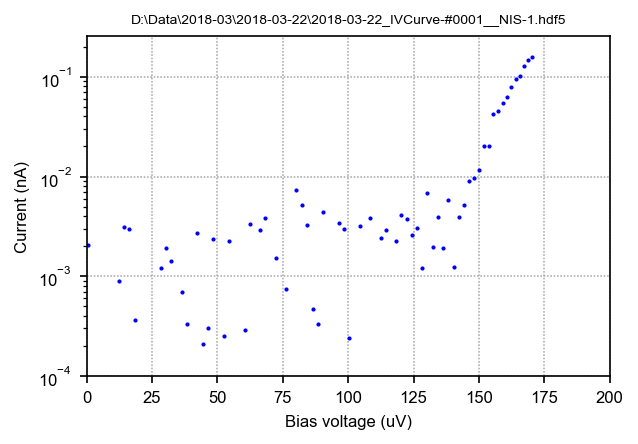

In [19]:
R = 10e3 + 12e3 + 2*1.7e3


v_ofs = (-10, 0.05)
ilim = 0.05
noise_sigmas = 1.95

# fp = r"D:\Data\2018-02\2018-02-22\2018-02-22_IVCurve-#0188_4001pts_testing.hdf5"
fp = r"D:\Data\2018-03\2018-03-22\2018-03-22_IVCurve-#0001__NIS-1.hdf5"
# Tb, Tv = fit_temperature(fp)

# fp = r"D:\Data\2018-02\2018-02-22\2018-02-22_IVCurve-#0188_4001pts_testing.hdf5"
bias, current, voltage = process_data(*get_data(fp), R=R)


fig, ax = plt.subplots(1,1)

ax.plot(bias, current, 'bo', ms=1)
# ax.plot(sample_vvals, sample_ivals, 'r-')
 
ax.set_yscale('log')
ax.set_xlim(0, 200)
ax.set_ylim(1e-4, None)
ax.grid(dashes=[1,1])
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
ax.set_title(fp, size='small')

Text(0.5,1,'D:\\Data\\2018-03\\2018-03-22\\2018-03-22_IVCurve-#0001__NIS-1.hdf5')

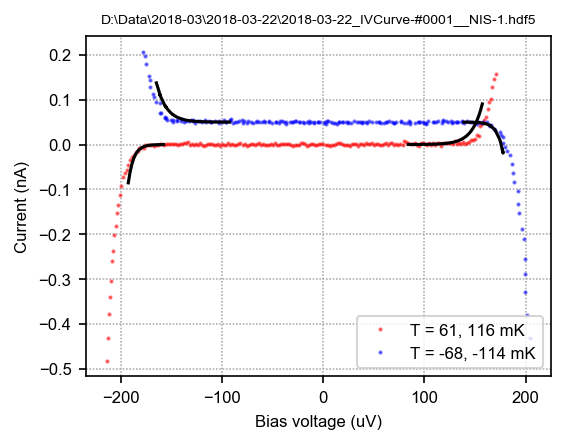

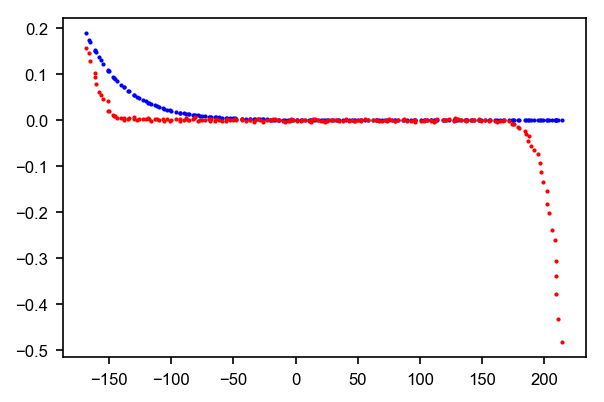

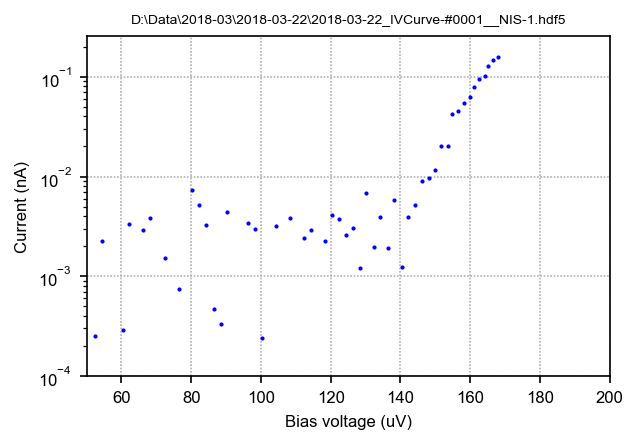

In [31]:
R = 10e3 + 12e3 + 2*1.7e3


v_ofs = (-10, 0.05)
ilim = 0.05
noise_sigmas = 1.95

# fp = r"D:\Data\2018-02\2018-02-22\2018-02-22_IVCurve-#0188_4001pts_testing.hdf5"
fp = r"D:\Data\2018-03\2018-03-22\2018-03-22_IVCurve-#0001__NIS-1.hdf5"
Tb, Tv = fit_temperature(fp)

# print(Tb, Tv)

# fp = r"D:\Data\2018-02\2018-02-22\2018-02-22_IVCurve-#0188_4001pts_testing.hdf5"
bias, current, voltage = process_data(*get_data(fp), R=1.6*R)

v2, i_linfit, T_slope = fit_linslope(current, voltage)

fig, ax = plt.subplots(1,1)
ax.plot(v2, i_linfit, 'bo', ms=1)
ax.plot(voltage, current, 'ro', ms=1)

fig, ax = plt.subplots(1,1)
ax.plot(bias, current, 'bo', ms=1)

# ax.plot(sample_vvals, sample_ivals, 'r-')
 
ax.set_yscale('log')
ax.set_xlim(50, 200)
ax.set_ylim(1e-4, None)
ax.grid(dashes=[1,1])
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
ax.set_title(fp, size='small')

NameError: name 'df' is not defined

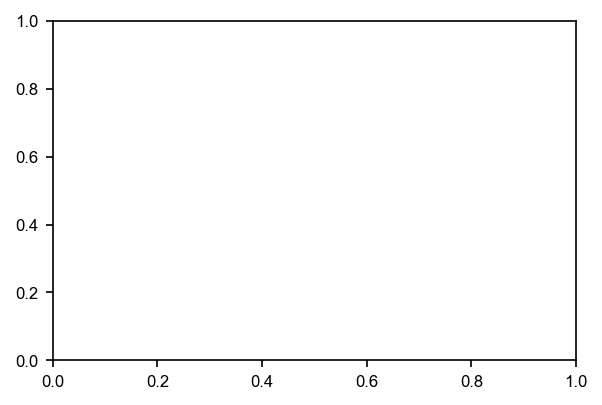

In [21]:
fig, ax = plt.subplots(1,1)

fltr201 = (df['npts'] == 201) & (df['T_bias'] < 80)
fltr401 = (df['npts'] == 401) & (df['T_bias'] < 80)
fltr801 = (df['npts'] == 801) & (df['T_bias'] < 80)
fltr1601 = (df['npts'] == 1601) & (df['T_bias'] < 80)

# ax.plot(df[fltr201]['idx'], df[fltr201]['T_bias'], 'o-', ms=2, label='200 pts')
ax.plot(df[fltr401]['idx'], df[fltr401]['T_bias'], 'o-', ms=2, label='400 pts')
ax.plot(df[fltr801]['idx'], df[fltr801]['T_bias'], 'o-', ms=2, label='800 pts')
ax.plot(df[fltr1601]['idx'], df[fltr1601]['T_bias'], 'o-', ms=2, label='1600 pts')


ax.legend()
ax.set_ylabel('T (mK)')
ax.set_xlabel('Run number')

# print(df[fltr201]['T_bias'].mean(), df[fltr201]['T_bias'].std())
print(df[fltr401]['T_bias'].mean(), df[fltr401]['T_bias'].std())
print(df[fltr801]['T_bias'].mean(), df[fltr801]['T_bias'].std())
print(df[fltr1601]['T_bias'].mean(), df[fltr1601]['T_bias'].std())

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


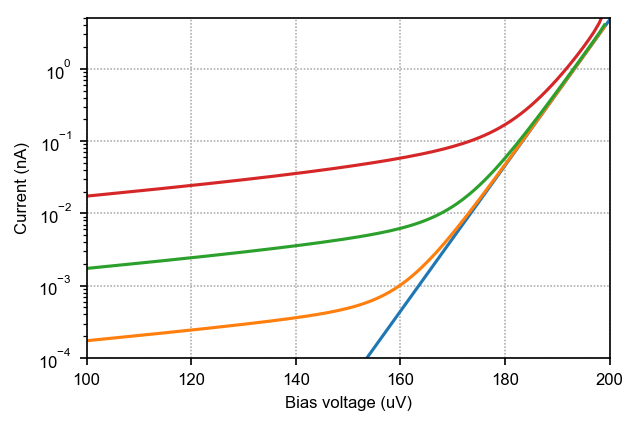

In [179]:
### Just the model
RT = 7.7e3
TN = 50e-3
Delta = 200e-6 * constants.e
I0 = (2 * np.pi * Delta * constants.k * TN)**.5 / (2 * constants.e * RT)

Vvals = np.linspace(1e-6, 400e-6, 400)
Ivals = I0 * np.exp((- Delta + constants.e * Vvals)/(constants.k * TN))

gammas = np.array([1e-5, 1e-4, 1e-3])
Icorrs = []
for g in gammas:
    Icorrs.append(Ivals + g*Vvals / (RT * (1. - (constants.e*Vvals/Delta)**2)))


fig, ax = plt.subplots(1,1)
ax.plot(Vvals * 1e6, Ivals * 1e9)
ax.set_yscale('log')
ax.set_xlim(100, 200)
ax.set_ylim(1e-4, 5)
ax.grid(dashes=[1,1])
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')

for Icorr in Icorrs:
    ax.plot(Vvals * 1e6, Icorr * 1e9)

Text(0,0.5,'Current (nA)')

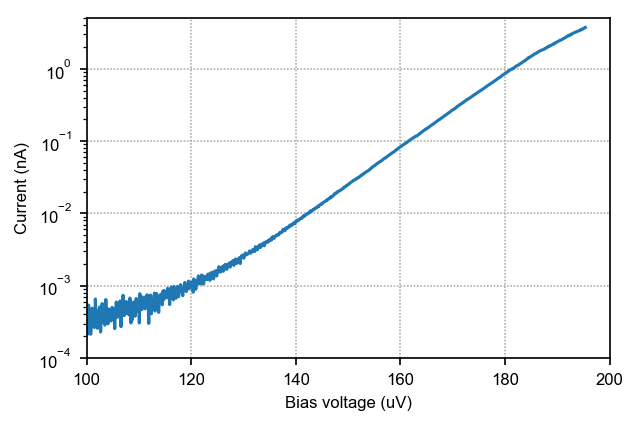

In [185]:
fp = r"..\analysis\NIS_fit\from_Pekola\NIS3_97mK.txt"
data = np.loadtxt(fp)

sample_ivals = data[:,0] * 1e9
sample_vvals = data[:,1] * 1e6

fig, ax = plt.subplots(1,1)
ax.plot(sample_vvals, sample_ivals)
ax.set_yscale('log')
ax.set_xlim(100, 200)
ax.set_ylim(1e-4, 5)
ax.grid(dashes=[1,1])
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')

(4601, 2)

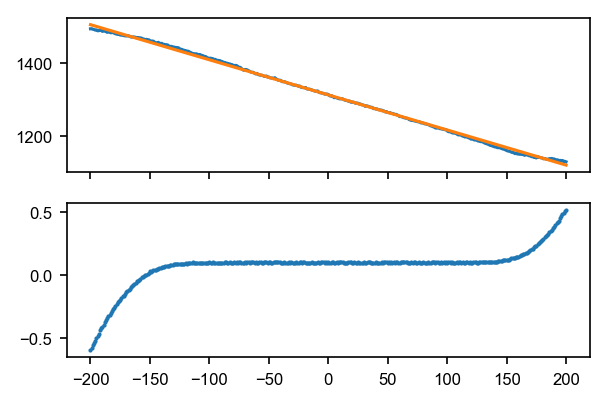

In [229]:
fp = r"D:\Data\2018-02\2018-02-21\2018-02-21_IVCurve-#0219_401pts_100mK.hdf5"
bias, current, voltage = get_data(fp)
bias *= 1e6
current *= 1e9
voltage *= 1e6

fltr = slice(bias.size//2 - bias.size//6, -bias.size//2 + bias.size//6, None)
p = np.polyfit(bias[fltr], voltage[fltr], 1)
b2v = p[0]

fig, (ax, bx) = plt.subplots(2, 1, sharex=True)
ax.plot(bias, voltage)
ax.plot(bias, bias * b2v + p[1])

bx.plot(bias, current, 'o', ms=1)



# bias *= 1e6
# voltage *= -1e6
# voltage -= voltage.mean()
# current *= 1e9
# current -= current[current.size//2]

# iof, bof = find_offset(current, bias)
# bias -= bof
# current -= iof
# bias -= current * R * 1e-3

# _, vof = find_offset(current, voltage)
# voltage -= vof

In [230]:
b2v

-0.95700094298028326